This notebook will compare the vertical eddy diffusivity and viscosity at the the VENUS nodes. Two simulations are compared - 

1. dwr_notsmooth_kappa10_winds (rn_avt0=1e-5, rn_avt0 = 1e-4)
2. dwr_diff1e-6_visc1e-5_wind (rn_avt0= 1e-6, rn_avm0 = 1e-5)


Both used winds

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os

import seaborn as sns

from salishsea_tools.nowcast import research_VENUS

%matplotlib inline

In [2]:
sns.set_style('darkgrid')
sns.set_color_codes()

In [3]:
# Load the data. Path name can be changed to look at different data.  
runs=['dwr_notsmooth_kappa10_winds','dwr_diff1e-6_visc1e-5_wind']
base='/data/nsoontie/MEOPAR/SalishSea/results/stratification/'
sals={}; depths={}; avms={}; avds={}; Ws={};depthws={}; Us={}; Vs={}
for run in runs:
    path = os.path.join(base,'{}/SalishSea_1d_20030819_20030927_grid_T.nc'.format(run))
    f = nc.Dataset(path,'r');
    sals[run]=f.variables['vosaline']
    depths[run] = f.variables['deptht'] 
    T_lat = f.variables['nav_lat']
    T_lon = f.variables['nav_lon']

    #Loading eddy viscosity/diffusivity data on the vertical grid
    path = os.path.join(base,'{}/SalishSea_1d_20030819_20030927_grid_W.nc'.format(run))
    f = nc.Dataset(path,'r');
    avms[run]=f.variables['ve_eddy_visc']
    avds[run]= f.variables['ve_eddy_diff'] #
    Ws[run]=f.variables['vovecrtz']
    depthws[run] = f.variables['depthw']

    #Loading data on the ugrid
    path = os.path.join(base,'{}/SalishSea_1d_20030819_20030927_grid_U.nc'.format(run))
    f = nc.Dataset(path,'r');
    Us[run]=f.variables['vozocrtx']


    #Loading data on the ugrid
    path = os.path.join(base,'{}/SalishSea_1d_20030819_20030927_grid_V.nc'.format(run))
    f = nc.Dataset(path,'r');
    Vs[run]=f.variables['vomecrty']


grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy=grid.variables['Bathymetry']


In [4]:
bg = {runs[0]: {'visc': 1e-4, 'diff': 1e-5},
      runs[1]: {'visc': 1e-5, 'diff': 1e-6}
      }

SITES= research_VENUS.SITES['VENUS']


In [5]:
def compare_visc_diff(j, i,station,zmin=0, zmax=50, xmin=-7,xmax=-2):
    """Compare vertical eddy diff and viscosity at time t and gridpoint (i,j)"""
    
    colors=['b','g']
    fig, axs = plt.subplots(1,2,figsize=(15,3))
    for run, c in zip(runs, colors):
        #diff
        title = ' Diffusivity averaged over 40 days  - {}'.format( station )
        ax=axs[0]
        avd=avds[run][:,:,j,i]
        avd=np.nanmean(np.ma.masked_values(avd,0),axis=0)
        ax.plot(np.log10(avd),depthws[run],'-o',label=run,color=c)
        ax.plot(np.log10([bg[run]['diff'], bg[run]['diff']]), [depthws[run][0], depthws[run][-1]],
                '--', color=c, label='background')
        ax.set_xlabel('Log base 10 of diffusivity (m^2/s)')
        ax.set_title(title)
        
        #visc
        title = ' Viscosity averaged over 40 days  - {}'.format(station )
        ax=axs[1]
        avm=avms[run][:,:,j,i]
        avm=np.nanmean(np.ma.masked_values(avm,0),axis=0)
        ax.plot(np.log10(avm),depthws[run],'-o',label=run,color=c)
        ax.plot(np.log10([bg[run]['visc'], bg[run]['visc']]), [depthws[run][0], depthws[run][-1]],
                '--', color=c, label='background')
        ax.set_xlabel('Log base 10 of Viscosity (m^2/s)')
        ax.set_title(title)

    for ax in axs:
        ax.legend(loc=0)
        ax.set_ylabel('Depth [m]')
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([zmax,zmin])
    
    return fig

Plan - average the eddy diff/visc over the full 40 days for each simulation. Plot at Central and East.

## Central
* Blue = case with rn_avt0=1e-5, rn_avm0=1e-4
* Green = case with rn_avt0=1e-6, rn_avm0=1e-5

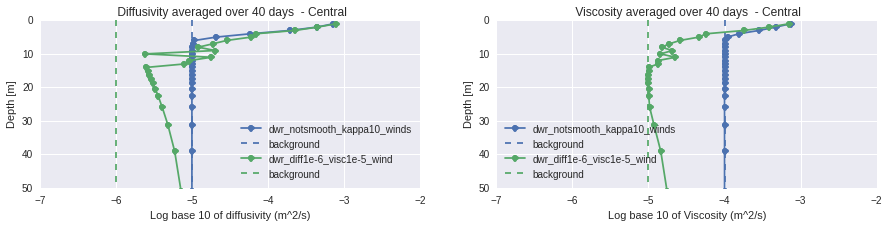

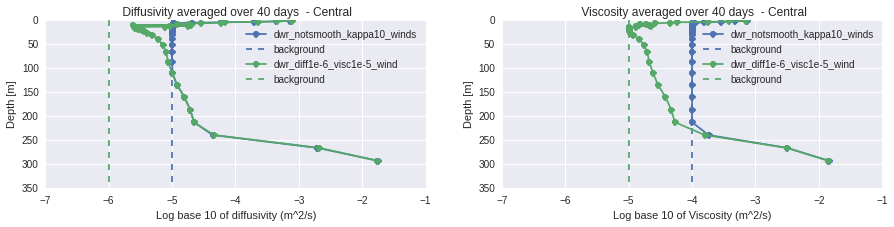

In [6]:
site='Central'
fig =compare_visc_diff(SITES[site]['j'], SITES[site]['i'],site)
fig =compare_visc_diff(SITES[site]['j'], SITES[site]['i'],site, zmin=0, zmax=350,xmin=-7,xmax=-1)

* In the higher eddy case, GLS viscosity is basically not activated between 5m and 200m.
* In the two cases, values for viscosty are similar below 250m and in the very surface (be careful, log scale). 
* Similarly, values for diffusivity are similar below 120m and in the surface.
* Diffusivity is noisy in the surface layer between 10m and 15m for the lower eddy case. 
* In the higher eddy case, GLS diffusivity is not activated in the between ~10m and ~120m. What sets the ~120 m depth?
* In the green line (lower eddy case), the background viscosity departs from the background vakue at aviout 12 m depth. This corresponds to a large kink in the diffusivity.

##East

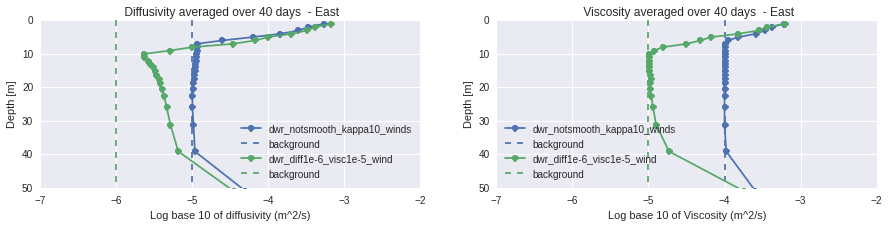

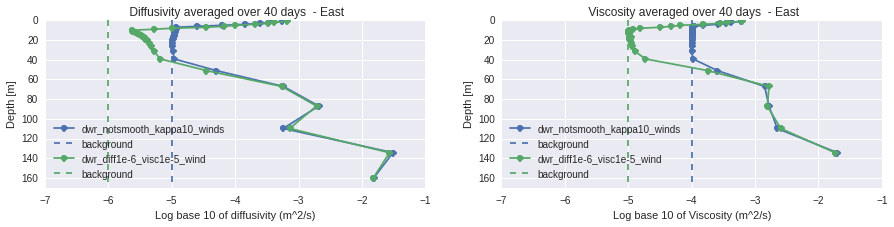

In [7]:
site='East'
fig =compare_visc_diff(SITES[site]['j'], SITES[site]['i'],site)
fig =compare_visc_diff(SITES[site]['j'], SITES[site]['i'],site, zmin=0, zmax=170,xmin=-7,xmax=-1)

* Why is the bottom point for the diffusivity deeper than the viscosity. I thought they were both on w grid...
* At depth (below 70m), both cases match reasonably well in both diffusivity and viscosity.
* In the higher eddy case (blue), GLS viscosity is not activated from ~ 7m to 40 m. It is activated over almost the full water column in the other case (green).
* Interestingly, for the green line, the background visc kicks in around 10 m. This corresponds to a kink in the diffsuvity curve. This suggests that these parameters are linked. 

#Summary
* I'm only looking at two places, so it might be unfair to say this is representative of the entire SoG.
* I've plotted a time average over the full 40 day simulation. Could there be 'noise' because of temporal variabilty in mixing?
* GLS seems to kick in at the surface when wind is activated. But in an average sense, there are some differences in the diff/visc profiles between cases? I should look more closely at how NEMO deals with miixing near the surface. Are there any limitations.
* It seems that the eddy coeffcients in the "intermediate" depth ranges are over esimated in the high eddy case. That is, there is a depth range for which NEMO is consisntly using the background value. If the background value is reduced, then this depth range decreases or disappears.  It is interesting that this depth range very different at central and east. I believe East has a more interesting current structure (Rich's boundary current?) and so perhaps the shear in the GLS kicks in.

I think it is clear that the background viscosity 10^-4 is too high. 1e-5 seems resonable but we might even be able to go lower. I'm still not sure about changing the background diff from 1e-5 to 1e-6. The profiles look 'noisy' but is that bad if we stay stable?

Is there going to be a different behaviour NEMO 3.6? Something to look into.  Regardless, we should use rn_avm0=1e-5 in the 3.4 nowcasts. 